In [4]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json
from vnpy.trader.app.ctaStrategy import BacktestingEngine
from vnpy.trader.utils import htmlplot

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181129 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

#
SOB = []
Signal = []

In [5]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################


# 策略继承CtaTemplate

class MoMStrategy(CtaTemplate):
    """MoMStrategy"""
    className = 'MoMStrategy'
    author = 'yuanhongjian'
    
    
    # 策略参数（与参数列表对应）
    # 参数设置

    ShortMoMPeriod = 12; LongMoMPeriod = 30

    '''
    SOBthres = 40
    SOBexit = -20
    SOBlookback = 50
    '''
    lot = 10000          # 设置手数
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['ShortMoMPeriod','LongMoMPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']
    stopRatio = 0.03
    
    nPos = 0
    fixsize = 1000
    Ratio = 0.02
    proportion = 2
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
#        self.onBarStopLoss(bar)
#        self.onBarfixedaddposition(bar)
        
        
    def onBarfixedaddposition(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
    # 固定损失加仓激进版模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 4):    # 持有多头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if lastOrder/bar.close-1 >= self.Ratio/self.proportion: 
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.buy(symbol,bar.close*1.02, add_fixsize)  # 加仓数量
                self.fixsize = add_fixsize + self.fixsize
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 4):    # 持有空头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if bar.close/lastOrder-1>= self.Ratio/self.proportion:
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.short(symbol,bar.close*0.98,self.fixsize)  # 目标仓位100手，分别加仓25手、20手、15手，10手
                self.fixsize = add_fixsize + self.fixsize       
    
        
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
        # 发出状态更新事件
        self.putEvent()
    
    def on15MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "15m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        # 指标计算
    
        
        MoMShort = ta.MOM(am.close, self.ShortMoMPeriod)
        MoMlong = ta.MOM(am.close, self.LongMoMPeriod)
        Stdlong = ta.STDDEV(am.close, self.LongMoMPeriod, nbdev=1)
        
        #prediction = ta.LINEARREG(am.close, self.regPeriod)
        #residual = (am.close - prediction) / am.close
        #residualSma = ta.MA(residual, self.residualSmaPeriod)
        #residualLma = ta.MA(residual, self.residualLmaPeriod)
        
        '''
        sob = get_sob(am.close)
        SOB.append(sob)
        signal = get_signal(SOB)
        Signal.append(signal)
        '''
        #print(SOB)
        #print(Signal)
        
        
        # 现象条件
        '''
        Buyresidual = residualSma[-1] > residualLma[-1]
        Sellresidual = residualSma[-1] < residualLma[-1]
        '''
        
        #breakUp = (am.close[-2] <= up[-2]) and (am.close[-1] > up[-2])
        #breakDn = (am.close[-2] <= low[-2]) and (am.close[-1] > low[-2])
        
        
        DI = MoMShort[-1] * MoMlong[-1] / (Stdlong[-1])**2
        BuyDI = (DI < -8) and (MoMlong[-1] > 0)
        SellDI = (DI < -4) and (MoMlong[-1] < 0)
    
        '''
        BuySOB = (SOB[-1] > self.SOBthres) and (Signal[-1] == self.SOBlookback)
        SellSOB = (SOB[-1] < self.SOBexit) and (Signal[-1] == -self.SOBlookback)
        '''
        
        # 构建进出场逻辑-------------------------------------------------
        if BuyDI and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif SellDI and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass
    
def get_sob(close_seq):
    # get SOB statistic
    if close_seq[-1] > close_seq[-2]:
        # SOB > 1
        sob = 2
        for i in range(3, MoMStrategy.SOBlookback+1):
            if close_seq[-1] > close_seq[-i]:
                sob += 1
            else:
                break
    else:
        # SOB < -1
        sob = -2
        for i in range(3, MoMStrategy.SOBlookback+1):
            if close_seq[-1] < close_seq[-i]:
                sob += -1
            else:
                break
    return sob
    

def get_signal(SOB):
    if len(SOB) < MoMStrategy.SOBlookback:
        signal = 0
    else:
        if SOB[-1] >= SOB[-2]:
            signal = 2
            for i in range(3, MoMStrategy.SOBlookback + 1):
                if SOB[-1] >= SOB[-i]:
                    signal += 1
                else:
                    break
        else:
            signal = -2
            for i in range(3, MoMStrategy.SOBlookback + 1):
                if SOB[-1] <= SOB[-i]:
                    signal += -1
                else:
                    break
    return signal

In [2]:
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(MoMStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

NameError: name 'engine' is not defined

In [4]:
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,rawData,status,symbol,tradeDatetime,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
0,空,,,0.0,,开仓,1,,14.5611,None,,,2018-06-04 06:30:00,1,20180604 06:30:00,10000,1,EOSUSDT:binance,1
1,空,,,0.0,,开仓,2,,14.2600,None,,,2018-06-04 11:01:00,2,20180604 11:01:00,1000,2,EOSUSDT:binance,2
2,多,,,0.0,,平仓,3,,14.4342,None,,,2018-06-04 11:06:00,3,20180604 11:06:00,11000,3,EOSUSDT:binance,3
3,空,,,0.0,,开仓,4,,14.5153,None,,,2018-06-10 04:00:00,4,20180610 04:00:00,10000,4,EOSUSDT:binance,4
4,空,,,0.0,,开仓,5,,14.1950,None,,,2018-06-10 07:49:00,5,20180610 07:49:00,2000,5,EOSUSDT:binance,5
5,空,,,0.0,,开仓,6,,13.9100,None,,,2018-06-10 08:24:00,6,20180610 08:24:00,4000,6,EOSUSDT:binance,6
6,空,,,0.0,,开仓,7,,13.6188,None,,,2018-06-10 08:59:00,7,20180610 08:59:00,8000,7,EOSUSDT:binance,7
7,多,,,0.0,,平仓,8,,12.3892,None,,,2018-06-11 01:32:00,8,20180611 01:32:00,24000,8,EOSUSDT:binance,8
8,空,,,0.0,,开仓,9,,11.6653,None,,,2018-06-11 11:45:00,9,20180611 11:45:00,10000,9,EOSUSDT:binance,9
9,多,,,0.0,,平仓,10,,10.6317,None,,,2018-06-13 02:59:00,10,20180613 02:59:00,10000,10,EOSUSDT:binance,10


2019-01-18 12:49:47.622095	计算按日统计结果
2019-01-18 12:49:47.716193	------------------------------
2019-01-18 12:49:47.716407	首个交易日：	2018-06-01 00:00:00
2019-01-18 12:49:47.716482	最后交易日：	2018-11-29 00:00:00
2019-01-18 12:49:47.716536	总交易日：	182
2019-01-18 12:49:47.716587	盈利交易日	68
2019-01-18 12:49:47.716641	亏损交易日：	54
2019-01-18 12:49:47.716693	起始资金：	100000
2019-01-18 12:49:47.716836	结束资金：	224,838.61
2019-01-18 12:49:47.716938	总收益率：	124.84%
2019-01-18 12:49:47.717263	年化收益：	164.62%
2019-01-18 12:49:47.717375	总盈亏：	124,838.61
2019-01-18 12:49:47.717473	最大回撤: 	-10,672.44
2019-01-18 12:49:47.717573	百分比最大回撤: -5.41%
2019-01-18 12:49:47.720008	总手续费：	3,749.79
2019-01-18 12:49:47.720850	总滑点：	2,180.0
2019-01-18 12:49:47.721244	总成交金额：	7,499,582.4
2019-01-18 12:49:47.721378	总成交笔数：	110
2019-01-18 12:49:47.721490	日均盈亏：	685.93
2019-01-18 12:49:47.721600	日均手续费：	20.6
2019-01-18 12:49:47.722037	日均滑点：	11.98
2019-01-18 12:49:47.722143	日均成交金额：	41,206.5
2019-01-18 12:49:47.722835	日均成交笔数：	0.6
2019-01-18 12:49:47.7240

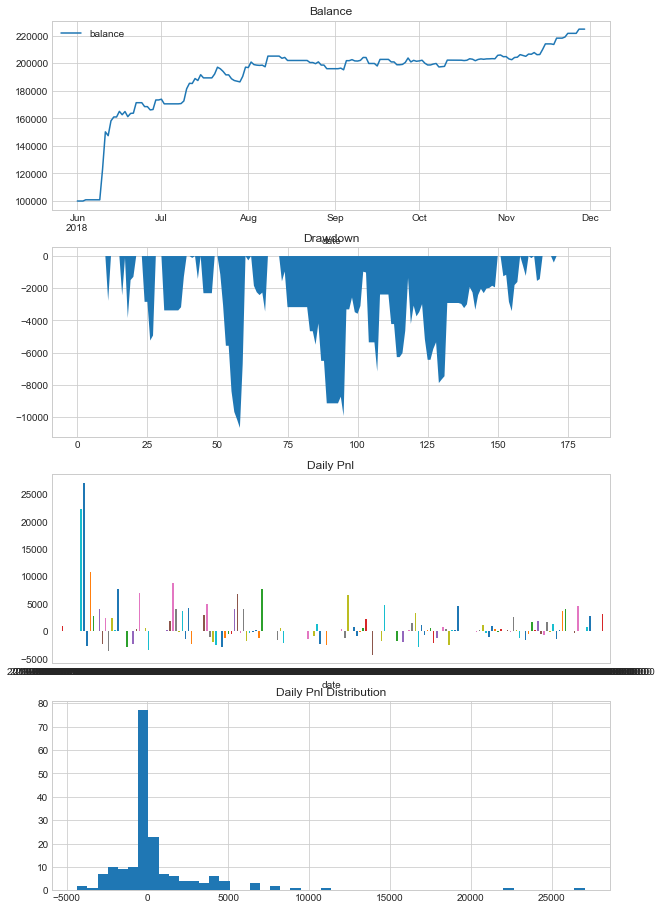

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2019-01-18 12:49:54.116459	计算回测结果
2019-01-18 12:49:54.139802	------------------------------
2019-01-18 12:49:54.139960	第一笔交易：	2018-06-04 11:06:00
2019-01-18 12:49:54.140021	最后一笔交易：	2018-11-27 18:13:00
2019-01-18 12:49:54.140078	总交易次数：	57
2019-01-18 12:49:54.140141	总盈亏：	124,838.61
2019-01-18 12:49:54.140200	最大回撤: 	-11,074.69
2019-01-18 12:49:54.140259	平均每笔盈利：	2,190.15
2019-01-18 12:49:54.140313	平均每笔滑点：	38.25
2019-01-18 12:49:54.140366	平均每笔佣金：	65.79
2019-01-18 12:49:54.140422	胜率		54.39%
2019-01-18 12:49:54.140482	盈利交易平均值	5,707.92
2019-01-18 12:49:54.140529	亏损交易平均值	-2,004.12
2019-01-18 12:49:54.140574	盈亏比：	2.85


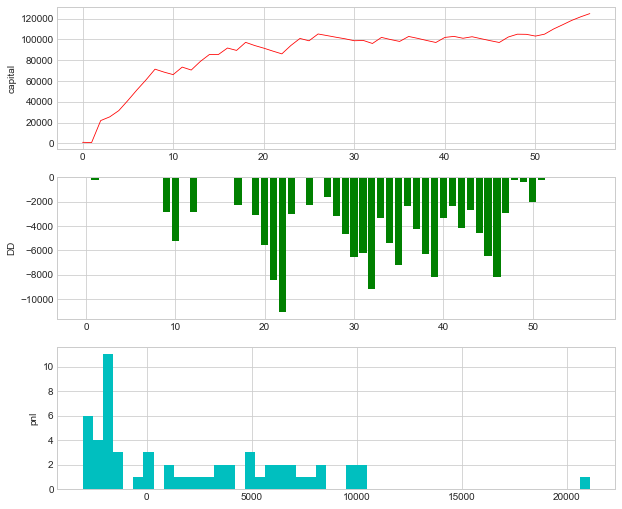

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [7]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2019-01-18 12:49:55.705785	计算按日统计结果


In [8]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-29 00:00:00
totalDays                           182
profitDays                           68
lossDays                             54
endBalance                       224839
maxDrawdown                    -10672.4
maxDdPercent                   -5.41203
totalNetPnl                      124839
dailyNetPnl                     685.926
totalCommission                 3749.79
dailyCommission                 20.6032
totalSlippage                      2180
dailySlippage                    11.978
totalTurnover               7.49958e+06
dailyTurnover                   41206.5
totalTradeCount                     110
dailyTradeCount                0.604396
totalReturn                     124.839
annualizedReturn                164.622
dailyReturn                    0.685926
returnStd                        3.3804
sharpeRatio                     3.14351
dtype: object


仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2019-01-18 16:33:55.041069	开始回测
2019-01-18 16:33:55.041425	策略初始化
2019-01-18 16:33:55.730433	数据载入完成, 时间段:[20180528 08:00,20180601 12:00);数据量:5700
2019-01-18 16:33:55.730780	初始化预加载数据成功, 数据长度:5700
2019-01-18 16:33:55.730909	策略初始化完成
2019-01-18 16:33:55.730967	策略启动完成
2019-01-18 16:33:55.731293	回测时间范围:[20180601 12:00,20181129 12:00)
2019-01-18 16:33:55.731392	当前回放的时间段:[20180601 12:00,20181129 12:00)
2019-01-18 16:34:14.474671	数据载入完成, 时间段:[20180601 12:00,20181129 12:00);数据量:258848
2019-01-18 16:34:14.781241	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2019-01-18 16:34:15.177413	我们的数据库没有 EOSUSDT:binance 这个品种
2019-01-18 16:34:15.178453	这些品种在我们的数据库里: []
2019-01-18 16:34:15.180795	数据载入完成, 时间段:[20180523 00:45,20180531 20:50);数据量:4790
2019-01-18 16:34:15.183978	WARNING: 该时间段:[20180603 12:01,20180603 12:15) 数据量为0!
2019-01-18 16:34:40.157956	回放结束ress: 100%    
2019-01-18 16:34:40.169807	策略日志已生成
2019-01-18 16:34:40.170054	

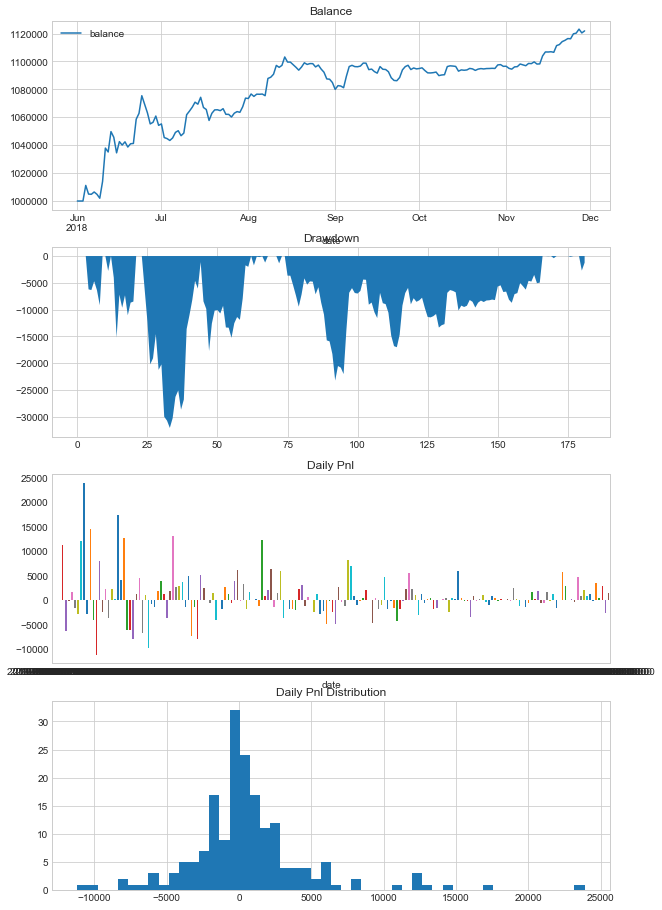

2019-01-18 16:34:45.688802	计算回测结果
2019-01-18 16:34:45.702284	交割单已生成
2019-01-18 16:34:45.702532	------------------------------
2019-01-18 16:34:45.702606	第一笔交易：	2018-06-25 08:00:00
2019-01-18 16:34:45.702661	最后一笔交易：	2018-11-29 11:58:00
2019-01-18 16:34:45.702723	总交易次数：	17
2019-01-18 16:34:45.702791	总盈亏：	121,876.86
2019-01-18 16:34:45.705775	最大回撤: 	-5,391.89
2019-01-18 16:34:45.705913	平均每笔盈利：	7,169.23
2019-01-18 16:34:45.706528	平均每笔滑点：	40.0
2019-01-18 16:34:45.711377	平均每笔佣金：	61.54
2019-01-18 16:34:45.712114	胜率		64.71%
2019-01-18 16:34:45.712484	盈利交易平均值	11,993.19
2019-01-18 16:34:45.712563	亏损交易平均值	-1,674.71
2019-01-18 16:34:45.712626	盈亏比：	7.16
2019-01-18 16:34:46.367526	策略回测统计图已保存


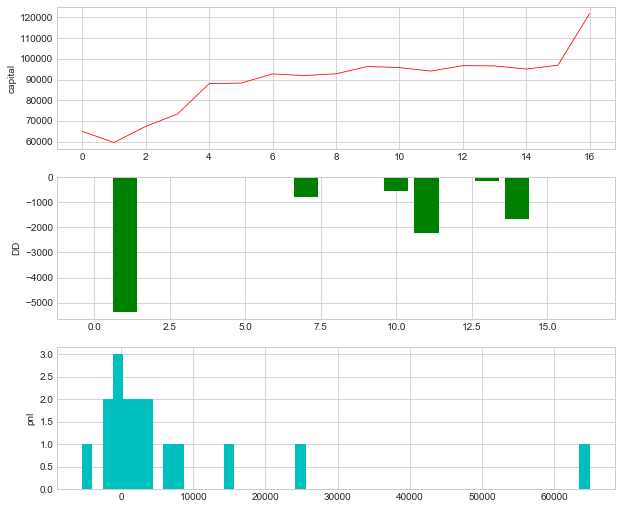

/Users/yuanhongjian/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.17-py3.6.egg/vnpy/trader/utils/htmlplot/core.py:8: UserWarning: Expected version of bokeh is 0.12.14, current version is 0.12.7
  warnings.warn("Expected version of bokeh is 0.12.14, current version is %s" % bokeh.__version__)


2019-01-18 16:34:49.024382	计算按日统计结果


In [6]:
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=100)
    engine.setEndDate(endDate)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.setLog(True)
    
#   在这里设置画图参数，目前只用设置freqency，支持的有 s(second) m(minute) h(hour) d(day)，也可以用timestamp, 例如： 1h -> timestamp(hours=1)
#   sample(输出用4hbar画图)
#   画图需要安装bokeh==0.12.14
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(1000000)
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    htmlplot.showTransaction(engine, frequency="1h")
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('tradeDatetime')
    return engine
#     return perfromanceDf, tradeDf

runBacktesting(MoMStrategy, {'symbolList': [
                                                       'EOSUSDT:binance',
#                                                'eos_quarter:OKEX'
                                                        ]},
                                                           '20180601 12:00', 
#                                                               '20181006 12:00', 
                                                           '20181129 12:00',0.002, 5/10000)